# 学習モデルを作成する

## 概要
- `0_create_training_data.ipynb`で作成したデータを学習データとしてBDEの予測モデルを作る。
- 学習済みBDE予測モデルを`model/estimate_single_bond_bde.json`として出力する。
- 回帰モデルとしてXGBoostを使用する。

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
# 学習データのzipファイルを解凍
train_data_zip ='data/all_train_data.zip'
train_data_file = '.'

if not os.path.exists(train_data_zip):
    print(f"The file {train_data_zip} does not exist.")
else:
    # ZIPファイルを開く
    with zipfile.ZipFile(train_data_zip, 'r') as zip_ref:
        # 解凍
        zip_ref.extractall(train_data_file)

In [3]:
# 学習データを取得
df = pd.read_csv('data/all_train_data.csv')
df

,3,4,5,6,8,9,12,17,18,19,...,123,124,125,126,127,128,129,130,131,bde
0,0,0,1,0,0,1,0,0,0,1,...,6,0,4,0,0,2,0,0,0,87.599001
1,0,0,2,0,0,0,0,0,0,1,...,6,4,3,0,2,0,0,0,0,82.344241
2,0,0,2,0,0,0,0,0,1,1,...,9,7,0,2,0,0,0,0,0,86.313863
3,0,1,1,0,0,0,0,0,0,1,...,6,3,4,0,2,0,0,0,0,95.898435
4,0,1,0,0,0,0,1,0,0,1,...,3,0,3,0,0,2,0,0,0,111.408575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484902,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,98.950012
484903,0,0,1,1,0,0,0,0,0,1,...,10,0,0,0,0,0,0,0,0,92.019802
484904,0,0,1,1,0,0,0,0,0,1,...,10,0,0,0,0,0,0,0,0,92.019802
484905,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,99.025940


In [4]:
# 学習データと検証データに分割
train, test = train_test_split(df, test_size = 0.1)

In [5]:
# 説明変数（分子内結合の特徴量）と目的変数（bde）を指定
features = [c for c in df.columns if c != 'bde']

X_train = train[features]
y_train = train['bde']
X_test = test[features]
y_test = test['bde']

In [6]:
# データ形式の変換
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# パラメータ設定
params = {"objective": "reg:squarederror"}

# 学習
model = xgb.train(
    params = params,
    dtrain = dtrain,
    evals = [(dtrain, "train"), (dtest, "test")],
)

[0]	train-rmse:8.44052	test-rmse:8.38202
[1]	train-rmse:6.80576	test-rmse:6.74959
[2]	train-rmse:5.76015	test-rmse:5.70842
[3]	train-rmse:5.04460	test-rmse:5.00098
[4]	train-rmse:4.53159	test-rmse:4.49708
[5]	train-rmse:4.25804	test-rmse:4.22715
[6]	train-rmse:3.95719	test-rmse:3.93294
[7]	train-rmse:3.77165	test-rmse:3.75192
[8]	train-rmse:3.60879	test-rmse:3.59294
[9]	train-rmse:3.52704	test-rmse:3.51344


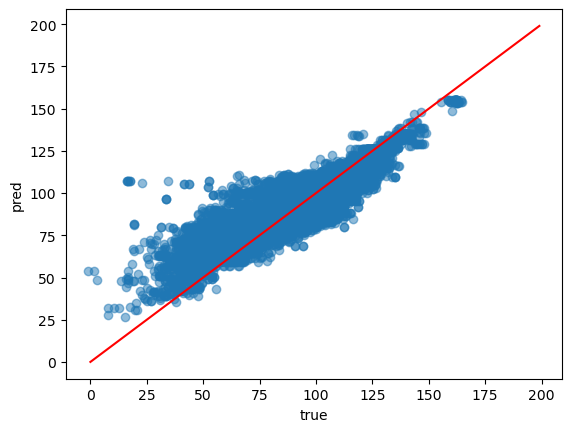

In [7]:
preds = model.predict(dtrain)
plt.scatter(y_train, preds, alpha = 0.5)
plt.plot(np.arange(0, 200), np.arange(0, 200), "r-")
plt.xlabel("true")
plt.ylabel("pred")
plt.show()

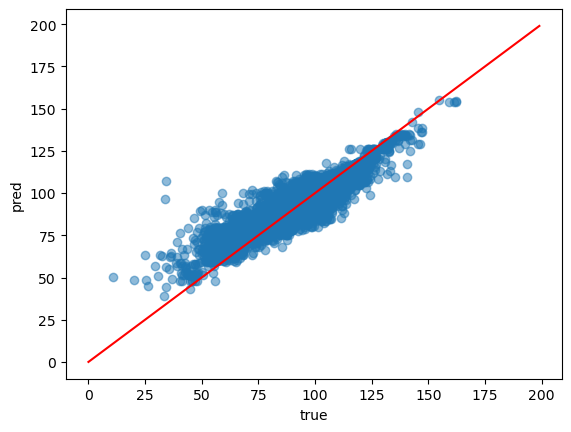

In [8]:
preds = model.predict(dtest)
plt.scatter(y_test, preds, alpha = 0.5)
plt.plot(np.arange(0, 200), np.arange(0, 200), "r-")
plt.xlabel("true")
plt.ylabel("pred")
plt.show()

In [9]:
# 学習済みモデルをjson形式でエクスポート
model.save_model('model/estimate_single_bond_bde.json')